In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import sklearn.linear_model as skl_lm
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [2]:
import pandas as pd

data = pd.read_excel (r'C:\Users\u22v09\Desktop\UPS_Data.xlsx') 

In [3]:
data.head()

,Unnamed: 0,EM4
0,2020-06-15 01:00:00,173
1,2020-06-15 01:30:00,189
2,2020-06-15 02:00:00,19
3,2020-06-15 04:00:00,108
4,2020-06-15 04:30:00,162


In [4]:
data=data.set_index('Unnamed: 0')

In [5]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy import stats


In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



def plotMovingAverage(series, window, plot_intervals=False, scale=1.645 , plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(16,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend",lw=1)

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond",lw=1)
        plt.plot(lower_bond, "r--",lw=1)
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10,lw=1)
        
    plt.plot(series[window:], label="Actual values",lw=1)
    plt.legend(loc="upper left")
    plt.grid(True)

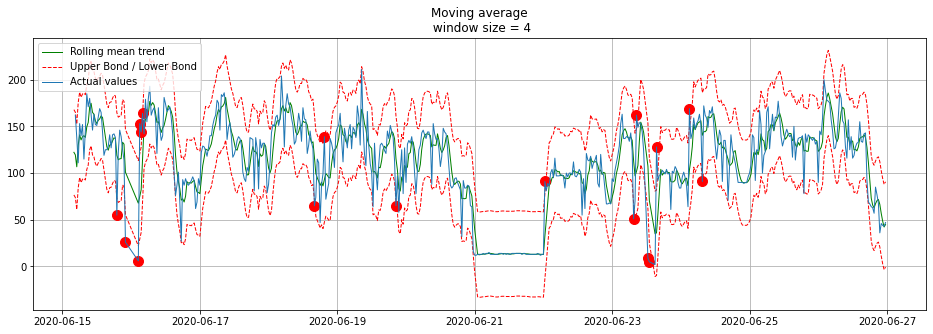

In [7]:
plotMovingAverage(data[['EM4']].dropna(), 4, plot_intervals=True, plot_anomalies=True) 

In [8]:

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [9]:
data_x = data.copy()

energy_anomaly = pd.DataFrame(data_x['EM4'])
rolling_mean = energy_anomaly.rolling(window=4).mean()
mae = mean_absolute_error(energy_anomaly[4:], rolling_mean[4:])
deviation = np.std(energy_anomaly[4:] - rolling_mean[4:])
lower_bond = rolling_mean - (mae + 1.645  * deviation)
upper_bond = rolling_mean + (mae + 1.645  * deviation)
anomalies = pd.DataFrame(index = energy_anomaly.index, columns = energy_anomaly.columns)
anomalies[energy_anomaly<lower_bond] = energy_anomaly[energy_anomaly<lower_bond]
anomalies[energy_anomaly>upper_bond] = energy_anomaly[energy_anomaly>upper_bond]
anomalies = anomalies.dropna()

In [10]:
data_x.loc[anomalies.index,'EM4'] = np.nan

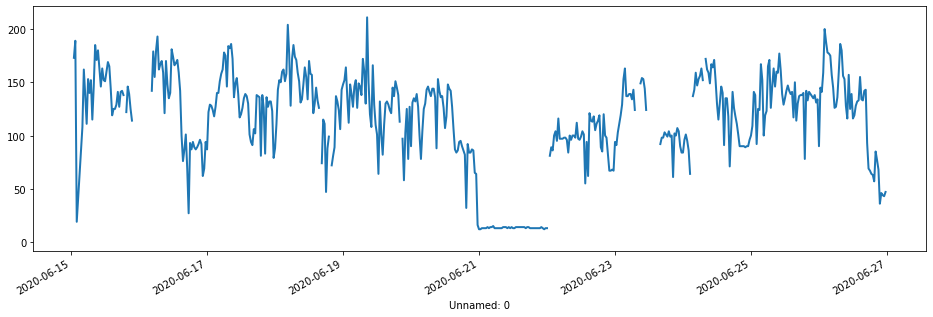

In [11]:
data_x['EM4'].plot(figsize = (16,5),lw=2)

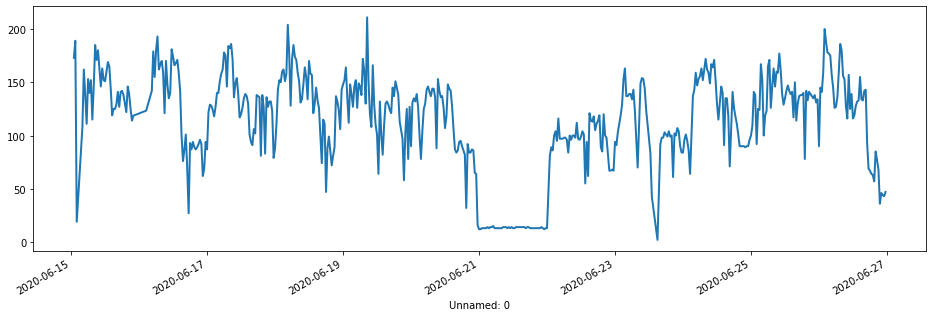

In [12]:
data_x['EM4'].interpolate(method='linear').plot(figsize = (16,5),lw=2)

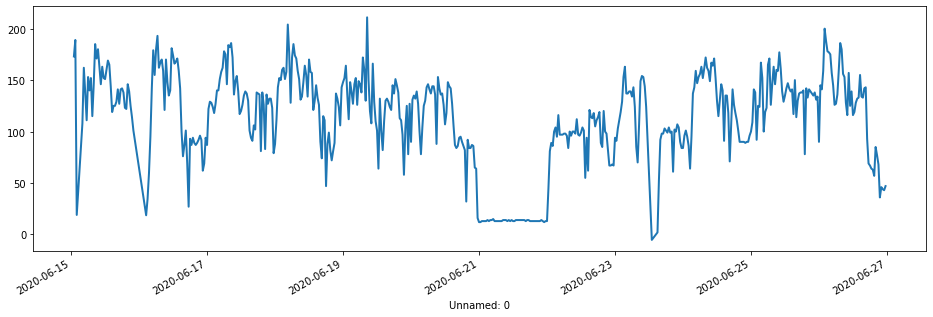

In [13]:
data_x['EM4'].interpolate(method='cubic').plot(figsize = (16,5),lw=2)

In [14]:

linear=data_x['EM4'].interpolate(method='linear')
##Dickey fuller test
from statsmodels.tsa.stattools import adfuller
result = adfuller(linear.fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.808106
p-value: 0.002825
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [15]:

cubic=data_x['EM4'].interpolate(method='cubic')
from statsmodels.tsa.stattools import adfuller
result = adfuller(cubic.fillna(0))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.247907
p-value: 0.000546
Critical Values:
	1%: -3.442
	5%: -2.867
	10%: -2.570


In [16]:
cubic=pd.DataFrame(cubic)

In [17]:
len(cubic)

558

In [18]:
train=cubic[0:500] 
test=cubic[500:]

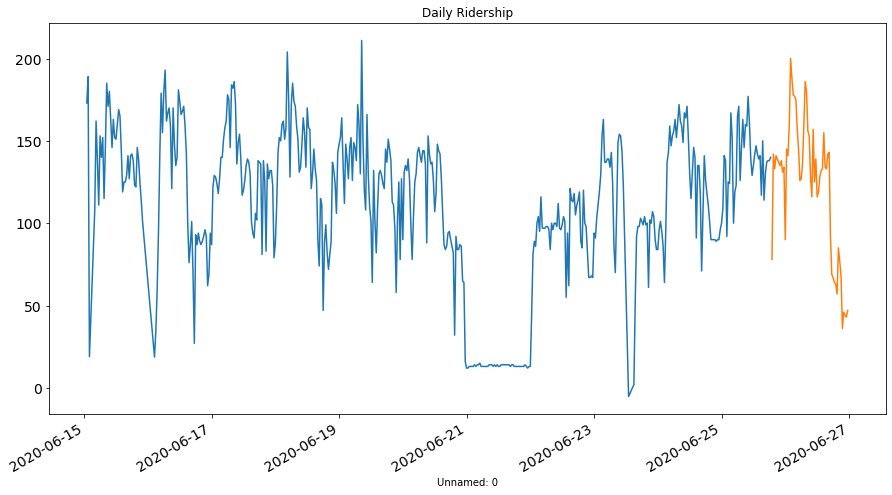

In [19]:
#Plotting data
train.EM4.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.EM4.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()


## Naive Method

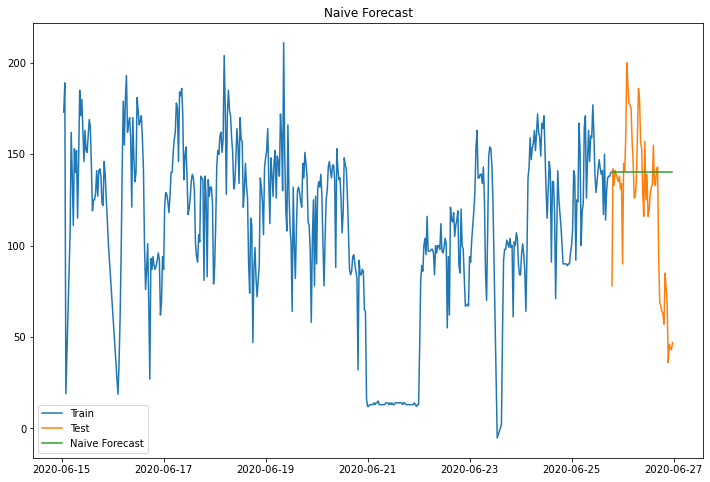

In [20]:
dd= np.asarray(train.EM4)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['EM4'], label='Train')
plt.plot(test.index,test['EM4'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.EM4, y_hat.naive))
print(rms)



44.57229694745845


## Moving Average

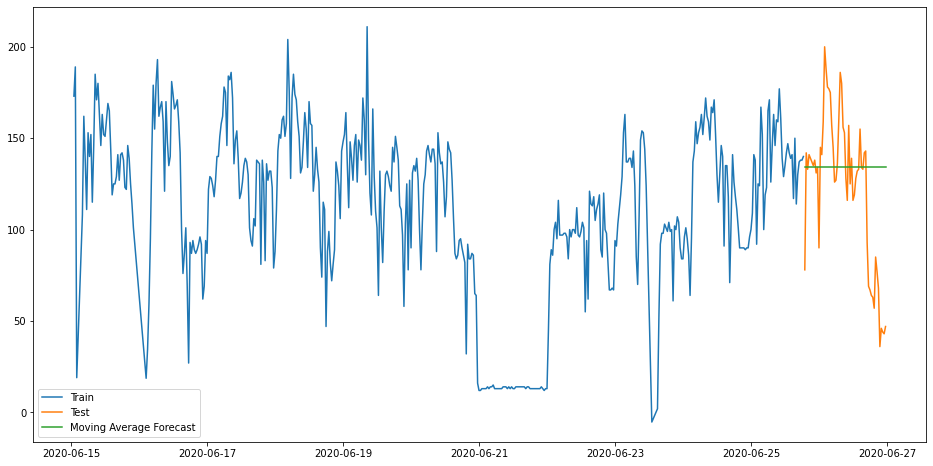

42.77811235376947


In [22]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['EM4'].rolling(10).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['EM4'], label='Train')
plt.plot(test['EM4'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.moving_avg_forecast))
print(rms)

In [23]:
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.moving_avg_forecast))
print(rms)

42.77811235376947


## Holt’s Linear Trend method

c:\users\u22v09\appdata\local\programs\python\python36\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


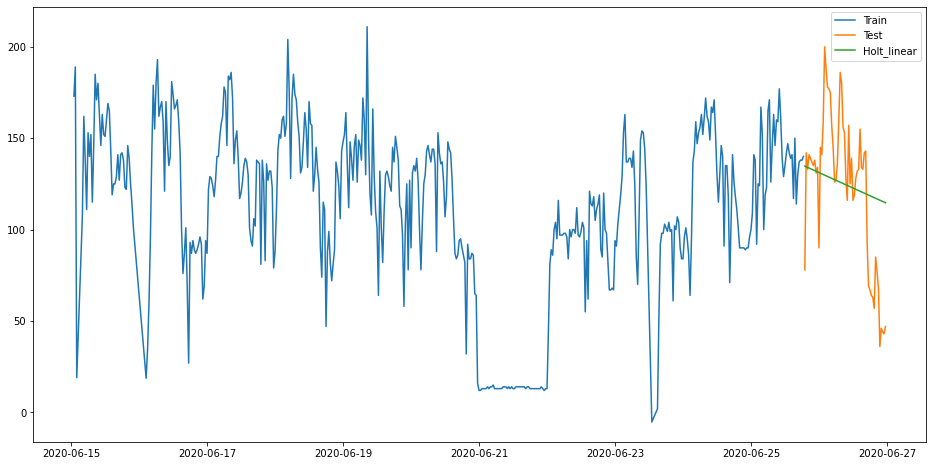

37.83243577568919


In [24]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['EM4'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['EM4'], label='Train')
plt.plot(test['EM4'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_linear))
print(rms)

In [25]:
rms = sqrt(mean_squared_error(test.EM4, y_hat_avg.Holt_linear))
print(rms)

37.83243577568919


In [26]:
TS=data.copy()
TS

,EM4
Unnamed: 0,
2020-06-15 01:00:00,173
2020-06-15 01:30:00,189
2020-06-15 02:00:00,19
2020-06-15 04:00:00,108
2020-06-15 04:30:00,162
...,...
2020-06-26 21:30:00,36
2020-06-26 22:00:00,46
2020-06-26 22:30:00,44


In [27]:
TS['EM4'].values

array([173, 189,  19, 108, 162, 138, 111, 153, 140, 152, 115, 146, 185,
       171, 180, 163, 146, 163, 152, 151, 160, 169, 165, 144, 119, 125,
       125, 129, 141, 127, 141, 142, 138,  55, 122, 146, 139, 125, 114,
        26,   6, 153, 144, 164, 142, 179, 155, 180, 193, 162, 167, 170,
       159, 121, 170, 148, 135, 140, 181, 174, 166, 168, 171, 159, 142,
       100,  76,  87, 101,  69,  27,  93,  87,  94,  89,  87,  89,  92,
        96,  92,  62,  69,  94,  87, 122, 129, 128, 124, 118, 127, 140,
       140, 151, 158, 162, 178, 175, 146, 184, 182, 186, 172, 136, 149,
       154, 139, 117, 120, 126, 135, 139, 137, 130, 101,  94,  91, 106,
       102, 138, 137, 136,  81, 138, 126,  83, 136, 127, 132, 132, 123,
        79,  88, 111, 143, 152, 150, 160, 162, 151, 158, 204, 176, 128,
       172, 185, 174, 171, 159, 151, 131, 134, 148, 164, 155, 134, 170,
       158, 157, 121, 130, 145, 133, 126,  65,  74, 115, 111,  47,  88,
        99, 139,  72,  81,  89, 137, 132, 124, 106, 143, 148, 15

In [28]:
# Time Series to Supervised Learning 


from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
#     n_vars = 1 if type(data) is list else data.shape[1]
    n_vars = 1 
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('T%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('T%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('T%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [29]:
values=list(TS['EM4'])
data = series_to_supervised(values, 5)
print(data)

     T1(t-5)  T1(t-4)  T1(t-3)  T1(t-2)  T1(t-1)  T1(t)
5      173.0    189.0     19.0    108.0    162.0    138
6      189.0     19.0    108.0    162.0    138.0    111
7       19.0    108.0    162.0    138.0    111.0    153
8      108.0    162.0    138.0    111.0    153.0    140
9      162.0    138.0    111.0    153.0    140.0    152
..       ...      ...      ...      ...      ...    ...
553     63.0     57.0     85.0     77.0     68.0     36
554     57.0     85.0     77.0     68.0     36.0     46
555     85.0     77.0     68.0     36.0     46.0     44
556     77.0     68.0     36.0     46.0     44.0     43
557     68.0     36.0     46.0     44.0     43.0     47

[553 rows x 6 columns]


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

X = data.drop('T1(t)', axis=1)
Y=data[['T1(t)']]

X_train,X_test, y_train,y_test = train_test_split(X , Y, random_state=20, test_size=0.1)


# Model initialization
regression_model = LinearRegression()

# Fit the data(train the model)
regression_model.fit(X_train, y_train)

y_predicted = regression_model.predict(X_test)
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)


# printing values
print('Slope:' ,regression_model.coef_)
print('Intercept:', regression_model.intercept_)
print('Root mean squared error: ', rmse)
print('R2 score: ', r2)



Slope: [[0.02063767 0.13376832 0.04240665 0.06778939 0.63668305]]
Intercept: [10.34436261]
Root mean squared error:  812.5099248362787
R2 score:  0.6674300206148358


In [31]:
X_train

len(y_predicted)

len(data)

553